In [38]:
import typing

import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns


%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
PATH_REL_ETE = "data/processed/ete.csv"

In [26]:
def aggregate_time_mean_ete(df_ete: pd.DataFrame, time_bucket_size: int, var_index: list[str]) -> pd.DataFrame:
    df_ete_agg =  df_ete.groupby(var_index+["molecule-ID", df_ete.index.get_level_values("t") // time_bucket_size], as_index=True).agg(np.mean)
    df_ete_agg.reset_index(level="t", drop=False, inplace=True)
    df_ete_agg["t"] = df_ete_agg["t"]*time_bucket_size
    df_ete_agg.set_index("t", append=True, inplace=True)
    return df_ete_agg


def get_dataset_ete_equi(
        conf: config.ExperimentConfig,
        experiment_path: pathlib.Path,
        var_index: list[str]
) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=var_index + ["molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [4]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/13-EEA1_short+Rab5_10x-long_time/7ded95ff")
PATH_EXPERIMENT_CONNECTED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/13-EEA1_short+Rab5_10x-long_time/7ded95ff')

In [5]:
CONF_CONNECTED = config.read_experiment_config(PATH_EXPERIMENT_CONNECTED / "13-EEA1_short+Rab5_10x-long_time.toml")
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_nod

### Get data

#### ETE

In [6]:
df_ete_conn = aggregate_time_mean_ete(get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED, var_index=["kappa", "d_end"]), time_bucket_size=10, var_index=["kappa", "d_end"])
df_ete_conn

R_x       R_y      R_z          R
kappa d_end molecule-ID t                                               
190.2 15.0  1           20000000   21.1113   3.33798 -51.8683  56.099462
                        20010000   22.3715   3.32621 -50.5283  55.359342
                        20020000   23.9349   1.88956 -48.7609  54.351405
                        20030000   23.1916   2.45618 -52.5876  57.526853
                        20040000   21.0607   3.62511 -53.9827  58.058819
...                                    ...       ...      ...        ...
            50          519960000  44.0820  -8.76189  35.9279  57.539616
                        519970000  46.7452  -9.84358  34.4316  58.885863
                        519980000  48.8575  -8.73757  33.7101  59.998094
                        519990000  47.8816  -9.66420  34.1878  59.622563
                        520000000  47.3523 -10.58040  33.7882  59.125524

[2500050 rows x 4 columns]

#### Kuhn length $l_K$

In [7]:
l_K_estimate_conn: pd.Series = pd.read_csv(PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "l_K-estimate.csv").iloc[0]
l_K_estimate_conn

kappa    190.200000
d_end     15.000000
l_K      381.557725
d_l_K      0.057164
Name: 0, dtype: float64

#### Bond length $l_b$

In [8]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

0.97

#### Contour length L

In [9]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

#### End monomer mass

In [10]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

1.5

#### Friction coefficient of end monomer $\zeta_e$

In [11]:
zeta_end_conn = l_K_estimate_conn["d_end"] / m_end_conn
zeta_end_conn

10.0

#### MSD

In [31]:
def with_transformed_time_msd_df(df_msd: pd.DataFrame):
    df_msd["t/LJ"] = df_msd.index.get_level_values("t").map(lambda t: t*0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()

In [32]:
df_msd_conn = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_conn)
with_transformed_time_msd_df(df_msd_conn)
df_msd_conn

,dR^2,kappa,d_end,t/LJ
t,,,,
20000000,0.000000,190.2,15.0,0.0
20010000,7.470236,190.2,15.0,25.0
20020000,12.636747,190.2,15.0,50.0
20030000,15.733537,190.2,15.0,75.0
20040000,19.781031,190.2,15.0,100.0
...,...,...,...,...
519960000,1154.704684,190.2,15.0,1249900.0
519970000,1161.786071,190.2,15.0,1249925.0
519980000,1160.750226,190.2,15.0,1249950.0


### Explore

#### Plot MSD

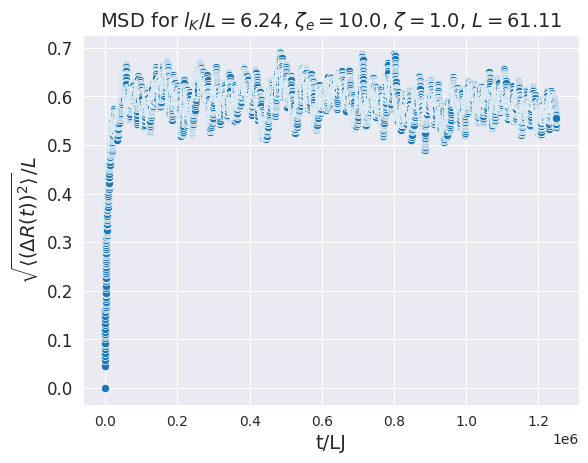

In [88]:
def plot_MSD(
        df_msd: pd.DataFrame,
        log_scale: bool,
        l_K: float,
        L_contour: float,
        zeta: float,
        zeta_e: float,
        title: typing.Optional[str] = None,
        ax: typing.Optional[plt.Axes] = None,
        label: typing.Optional[str] = None,
        color: typing.Optional[str] = None,
):
    df = df_msd.copy()
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    ax: plt.Axes = sns.scatterplot(
        df,
        x="t/LJ",
        y=dR_col,
        ax=ax,
        label=label,
        color=color,
    )

    title_prefix = "MSD"

    if log_scale:
        ax.set(xscale="log", yscale="log")
        title_prefix = "MSD on log-log scale"

    zeta_title = f"$\zeta_e={zeta_e:.1f}$, $\zeta={zeta:.1f}$"

    if np.round(zeta, 1) == np.round(zeta_e, 1):
        zeta_title = f"$\zeta_e = \zeta= {zeta:.2f}$"

    if title is None:
        title = f"{title_prefix} for $l_K/L={l_K/L_contour:.2f}$, {zeta_title}, $L={L_contour}$"

    ax.set(title=title)

plot_MSD(df_msd_conn, log_scale=False, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

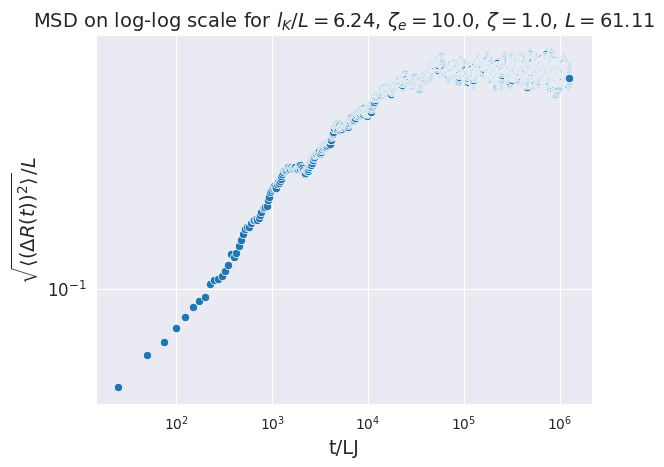

In [89]:
plot_MSD(df_msd_conn, log_scale=True, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

## Bare EEA1

In [22]:
PATH_EXPERIMENT_BARE = pathlib.Path("/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff")
PATH_EXPERIMENT_BARE

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff')

In [23]:
CONF_BARE = config.read_experiment_config(PATH_EXPERIMENT_BARE / "12-EEA1_short-long_time-rendered.toml")
CONF_BARE

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'n_relax_steps': 35000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=2, mem_per_cpu=2000), venv_path=PosixPath('/scratch/ws/0

### Get data

#### ETE

In [27]:
df_ete_bare = aggregate_time_mean_ete(
    get_dataset_ete_equi(CONF_BARE, PATH_EXPERIMENT_BARE, var_index=["kappa"]),
    time_bucket_size=10,
    var_index=["kappa"]
)
df_ete_bare

R_x       R_y      R_z          R
kappa molecule-ID t                                               
190.2 1           35000000  -11.2090 -18.61880  54.2396  58.431461
                  35010000  -12.1431 -15.40350  54.8017  58.206091
                  35020000  -10.6825 -10.82600  57.7616  59.730399
                  35030000  -11.9759 -11.76350  56.9861  59.407219
                  35040000  -11.4731  -7.79221  57.9553  59.591672
...                              ...       ...      ...        ...
      50          534960000 -21.5631  36.43180 -43.0082  60.348559
                  534970000 -21.3312  34.18480 -44.2859  59.873714
                  534980000 -21.5255  33.97930 -44.6883  60.124738
                  534990000 -14.1611  37.88690 -41.9876  58.300193
                  535000000 -14.9624  36.15070 -41.7827  57.241074

[2500050 rows x 4 columns]

#### Other

In [29]:
l_b = CONF_BARE.initial_system_config.system_config.bond_length
l_b

0.97

In [47]:
kappa = CONF_BARE.simulation_config.variables["kappa_start"]
kappa

190.2

In [78]:
l_K_bare = kremer_grest.bare_kuhn_length(kappa, l_b=l_b)
l_K_bare

368.018

#### MSD

In [34]:
df_msd_bare = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_bare)
with_transformed_time_msd_df(df_msd_bare)
df_msd_bare

,dR^2,kappa,t/LJ
t,,,
35000000,0.000000,190.2,0.0
35010000,20.286877,190.2,25.0
35020000,32.160526,190.2,50.0
35030000,34.070045,190.2,75.0
35040000,53.275140,190.2,100.0
...,...,...,...
534960000,1324.074449,190.2,1249900.0
534970000,1300.425401,190.2,1249925.0
534980000,1337.994253,190.2,1249950.0


### Explore

#### Plot MSD

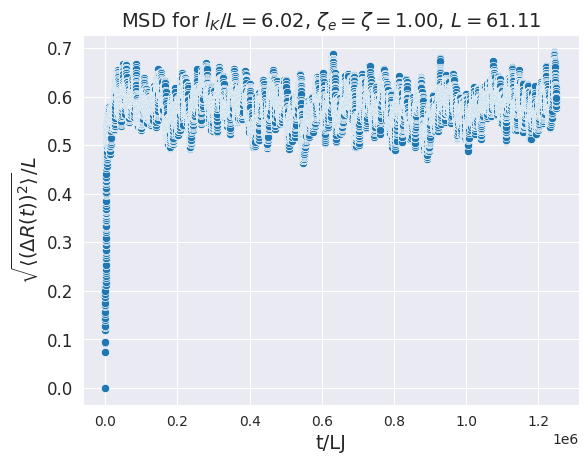

In [35]:
plot_MSD(df_msd_bare, log_scale=False, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

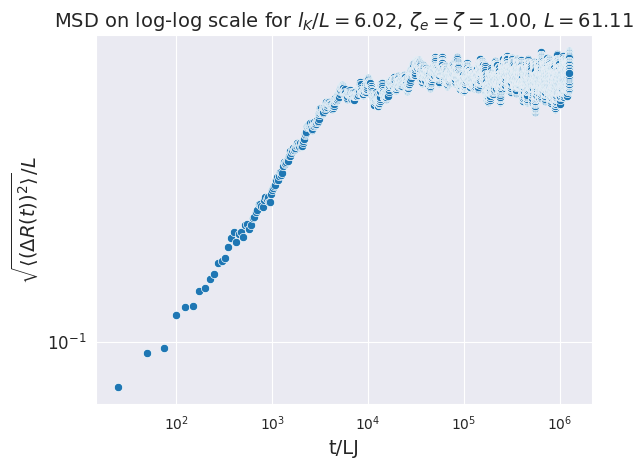

In [36]:
plot_MSD(df_msd_bare, log_scale=True, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

## Compare: EEA1+Rab5 vs EEA1

Text(0.3, 0.1, 'EEA1: $l_K/L =  6.02$ \nEEA1+Rab5: $l_K/L = 6.2438 \\pm 0.0009$ \n$\\Delta =  0.22L$')

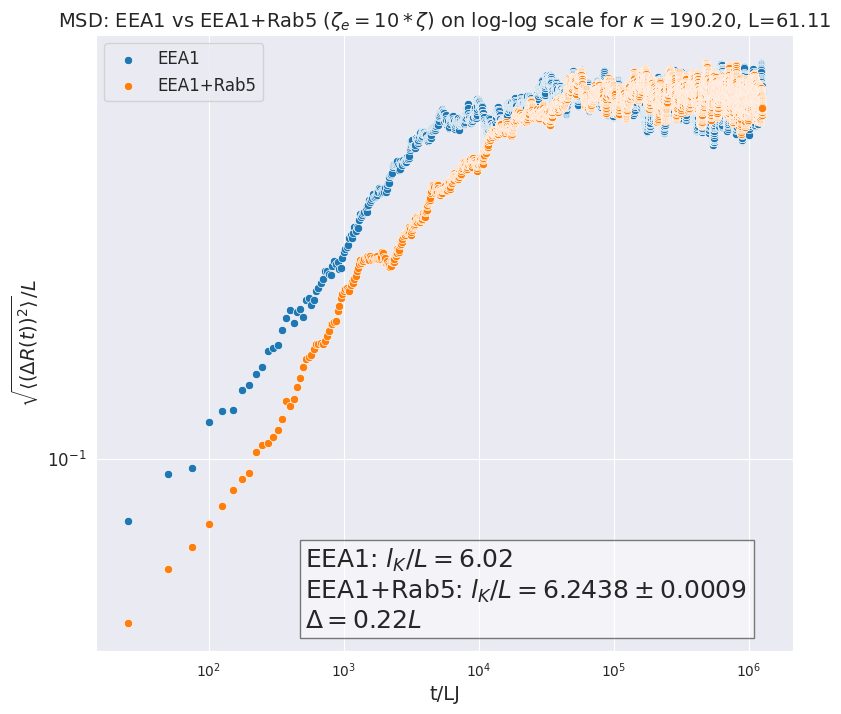

In [100]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots(figsize=(9,8))

plot_MSD(
    df_msd_bare,
    log_scale=True,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
)

plot_MSD(
    df_msd_conn,
    log_scale=True,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.3,
    y=.1,
    s=f"EEA1: $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.4f} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.4f}$ \n"
      f"$\Delta = {(l_K_estimate_conn['l_K'] - l_K_bare)/L_contour : .2f}L$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)